下载和缓存数据集

在整本书中，我们将在各种下载的数据集上训练和测试模型。在这里，我们实现几个函数来方便下载数据。首先，我们维护字典DATA_HUB，其将数据集名称的字符串映射到数据集相关的二元组上，这个二元组包含数据集的url和验证文件完整性的sha-1密钥。所有这样的数据集都托管在地址为DATA_URL的站点上。

In [22]:
import hashlib
import os
import tarfile
import zipfile
import requests

#这里面存储的键值对是一个name和一个包含（下载链接，sha1摘要）的元组
DATA_HUB =dict()
DATA_URL ='http://d2l-data.s3-accelerate.amazonaws.com/'

下面的download函数用来下载数据集，将数据集缓存在本地目录（默认情况下为../data）中，并返回下载文件的名称。如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配，我们将使用缓存的文件，以避免重复的下载。

In [23]:
def download(name,cache_dir=os.path.join('.','KaggleData')):
    "下载一个data_hub中的文件，返回本地文件名(绝对路径)"
    assert name in DATA_HUB,f"{name}不存在于{DATA_HUB}"
    url ,sha1_hash =DATA_HUB[name]
    #如果目录不存在则创建，存在也不会返回错误
    os.makedirs(cache_dir,exist_ok=True)
    #文件名为存储目录下的以url最后一个/后面的内容命名的文件
    fname =os.path.join(cache_dir,url.split('/')[-1])

    #如果下载的文件已经存在的话 就需要验证下载过程中有没有产生bit错误
    if os.path.exists(fname):
        sha1 =hashlib.sha1()
        with open(fname,'rb') as f:
            while True:
                #一次读2的20次方bit的数据
                data =f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest ==sha1_hash:
            #如果下载下来的文件的摘要和data_hub中的一样 就返回文件路径
            return fname
    
    print(f'正在从{url}下载{fname}...')
    #下面进行下载工作
    r =requests.get(url,stream=True,verify=True)
    with open(fname,'wb') as f:
        f.write(r.content)
    r.close()
    return fname

我们还实现了两个额外的实用函数：一个是下载并解压缩一个zip或tar文件，另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。

In [24]:
#下载并且解压一个zip或者tar文件 这里会调用上面的download函数
#这里的folder是指你需要在压缩文件的同级目录下创建一个保存解压后文件的新目录名字 默认不创建
def download_extract(name,folder =None):
    fname =download(name)

    #提取文件目录
    base_dir =os.path.dirname(fname)
    #提取文件的路径 并且将后缀分离出来
    data_dir,ext =os.path.splitext(fname)

    if ext =='.zip':
        #ZipFile读取一个压缩包内所有文件的名字存储到fp.namelist()返回的列表中
        fp =zipfile.ZipFile(fname,'r')
    elif ext in ('.tar','.gz'):
        fp =tarfile.open(fname,'r')
    else:
        assert False,'只有zip/tar文件可以被压缩'
    #将压缩文件解压到base_dir目录中
    fp.extractall(base_dir)
    #返回解压文件所在的指定的目录，如果没有指定目录则返回压缩文件的路径（不含后缀）
    return os.path.join(base_dir,folder) if folder else data_dir

    def download_all():
        #下载DATA_HUB中的所有文件
        for name in DATA_HUB:
            download(name)


    

注意，竞赛数据分为训练集和测试集。每条记录都包括房屋的属性值和属性，如街道类型、施工年份、屋顶类型、地下室状况等。这些特征由各种数据类型组成。例如，建筑年份由整数表示，屋顶类型由离散类别表示，其他特征由浮点数表示。这就是现实让事情变得复杂的地方：例如，一些数据完全丢失了，缺失值被简单地标记为“NA”。每套房子的价格只出现在训练集中（毕竟这是一场比赛）。我们将希望划分训练集以创建验证集，但是在将预测结果上传到Kaggle之后，我们只能在官方测试集中评估我们的模型。在 图4.10.2 中，“Data”选项卡有下载数据的链接。

开始之前，我们将使用pandas读入并处理数据，这是我们在 2.2节 中引入的。因此，在继续操作之前，您需要确保已安装pandas。幸运的是，如果你正在用Jupyter阅读该书，你可以在不离开笔记本的情况下安装

In [25]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

为方便起见，我们可以使用上面定义的脚本下载并缓存Kaggle房屋数据集。

In [26]:
DATA_HUB['kaggle_house_train'] =(
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce'
)

DATA_HUB['kaggle_house_test'] =(
    DATA_URL +'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90'
)

我们使用pandas分别加载包含训练数据和测试数据的两个CSV文件。

In [27]:
train_data =pd.read_csv('./KaggleData/kaggle_house_pred_train.csv')
test_data =pd.read_csv('./KaggleData/kaggle_house_pred_test.csv')

训练数据集包括1460个样本，每个样本80个特征和1个标签，而测试数据包含1459个样本，每个样本80个特征。

In [28]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


让我们看看前四个和最后两个特征，以及相应标签（房价）。

In [29]:
#iloc的两个参数分别为按照行索引和列索引 下面的意思是前四行的 前四列和后三列的数据
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


我们可以看到，在每个样本中，第一个特征是ID，这有助于模型识别每个训练样本。虽然这很方便，但它不携带任何用于预测的信息。因此，在将数据提供给模型之前，我们将其从数据集中删除。

In [30]:
#将训练集和测试集纵向链接 训练集最后一列不放入
all_features =pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

数据预处理

如上所述，我们有各种各样的数据类型。在开始建模之前，我们需要对数据进行预处理。让我们从数字特征开始。首先，我们应用启发式方法，将所有缺失的值替换为相应特征的平均值。然后，为了将所有特征放在一个共同的尺度上，我们通过将特征重新缩放到零均值和单位方差来标准化数据：
 
要验证这确实转换了我们的特征（变量），使特征具有零均值和单位方差，即  E[x−μσ]=μ−μσ=0 和 E[(x−μ)2]=(σ2+μ2)−2μ2+μ2=σ2 。直观地说，我们标准化数据有两个原因。首先，它方便优化。其次，因为我们不知道哪些特征是相关的，所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。

In [31]:
 #all_features.dtypes != 'object' 返回的是一个series 包含名称和属性 将属性为object的剔除
 #再通过dtypes返回一个不含有object属性的series
 #再用index返回这个series的索引
numeric_features=all_features.dtypes[all_features.dtypes != 'object'].index
#将上述的预处理方式应用到这些数据型特征上
all_features[numeric_features] =all_features[numeric_features].apply(
    lambda x:(x-x.mean())/(x.std())
)

#在标准化数据之后，所有数据均值为0，我们可以将缺失的值设为0
all_features[numeric_features].fillna(0)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0.348780,-0.740634,0.199972,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,0.157619
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,-0.059772,1.614603,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.446848,-0.602858
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0.627338,-0.740634,-0.081195,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,0.157619
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0.785188,-0.740634,-0.184783,3.874303,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,-1.363335
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,1.685860,0.776834,0.540332,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,2.131647,0.157619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,-2.195385,-0.740634,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.078492,-1.363335
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,-0.867591,-0.740634,-0.347564,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.815205,-1.363335
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0.478774,3.005615,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,-1.363335
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,-2.195385,-0.108355,-0.229178,-0.359539,-0.103313,-0.285886,-0.063139,1.144116,0.289865,-1.363335


接下来，我们处理离散值。这包括诸如“MSZoning”之类的特征。我们用一次独热编码替换它们，方法与前面将多类别标签转换为向量的方式相同(请参见 3.4.1节 )。例如，“MSZoning”包含值“RL”和“Rm”。将创建两个新的指示器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1。根据独热编码，如果“MSZoning”的原始值为“RL”，则:“MSZoning_RL”为1，“MSZoning_RM”为0。pandas软件包会自动为我们实现这一点。

In [32]:
#`Dummy_na=True` 将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
#get_dummies是把非数值类属性的取值都拿出来单独成一列，以0，1表示该行是否有这一特征
all_features =pd.get_dummies(all_features,dummy_na =True)
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


你可以看到，此转换会将特征的数量从79个增加到331个。最后，通过values属性，我们可以从pandas格式中提取NumPy格式，并将其转换为张量表示用于训练。

In [33]:
#获取数据集第零维的长度
n_train=train_data.shape[0]
#将特征的值提取出来放在列表中
train_features =torch.tensor(all_features[:n_train].values,dtype=d2l.float32)
test_features =torch.tensor(all_features[n_train:].values,dtype=d2l.float32)
#将标签拿出来单独存放
train_labels =torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=d2l.float32)

训练

首先，我们训练一个带有损失平方的线性模型。毫不奇怪，我们的线性模型不会让我们在竞赛中获胜，但线性模型提供了一种健全性检查，以查看数据中是否存在有意义的信息。如果我们在这里不能做得比随机猜测更好，那么我们很可能存在数据处理错误。如果一切顺利，线性模型将作为基线模型，让我们直观地知道简单的模型离报告最好的模型有多近，让我们感觉到我们应该从更酷炫的模型中获得多少收益。

In [34]:
loss =nn.MSELoss()
in_features =train_features.shape[1]

def get_net():
    net =nn.Sequential(nn.Linear(in_features,1))
    return net


对于房价，就像股票价格一样，我们关心的是相对数量，而不是绝对数量。因此，我们更关心相对误差 y−y^y ，而不是绝对误差 y−y^ 。例如，如果我们在俄亥俄州农村地区估计一栋房子的价格时，我们的预测偏差了10万美元，在那里一栋典型的房子的价值是12.5万美元，那么我们可能做得很糟糕。另一方面，如果我们在加州豪宅区的预测出现了这个数字的偏差，这可能是一个惊人的准确预测（在那里，房价均值超过400万美元）。

In [35]:
def log_rmse(net,features,labels):
    #为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds =torch.clamp(net(features),min=1,max=float('inf'))
    rmse =torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))

    return rmse.item()

与前面的部分不同，我们的训练函数将借助Adam优化器（我们将在后面更详细地描述它）。这个优化器的主要吸引力在于，尽管在提供无限资源进行超参数优化方面没有做得更好（有时更差），但人们发现它对初始学习率不那么敏感。

In [36]:
def train(net,train_features,train_labels,test_features,test_labels,
        num_epochs,learning_rate,weight_decay,batch_size):
    #这两个列表用来存放损失
    train_ls,test_ls =[],[]
    train_iter =d2l.load_array((train_features,train_labels),batch_size)

    optimizer =torch.optim.Adam(net.parameters(),
                                lr =learning_rate,
                                weight_decay=weight_decay)
    
    for epoch in range(num_epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l =loss(net(X),y)
            l.backward()
            optimizer.step()
        #训练好了之后可以用模型计算训练损失了
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
        
    return train_ls,test_ls


k折交叉验证

你可能还记得，我们在讨论模型选择的部分（ 4.4节 ）中介绍了K折交叉验证。这有助于模型选择和超参数调整。我们首先需要一个函数，在 K 折交叉验证过程中返回第 i 折的数据。它选择第 i 个切片作为验证数据，其余部分作为训练数据。注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，我们肯定会做一些更聪明的改变。但是这种改变所增加的复杂性可能会使代码看起来更乱。在这里可以忽略这些改变，因为我们的问题很简单。

In [37]:
def get_k_fold_data(k,i,X,y):
    assert k >1
    fold_size =X.shape[0]//k
    X_train,y_train =None,None

    for j in range(k):
        index =slice(j*fold_size,min((j+1)*fold_size,X.shape[0]))
        X_part,y_part =X[index,:],y[index]

        if j ==i:
            #如果是第i折组数据 则用来作为我们的验证集
            X_valid,y_valid=X_part,y_part
        elif X_train is None:
            X_train,y_train =X_part,y_part
        else:
            X_train =torch.cat([X_train,X_part],dim=0)
            y_train =torch.cat([y_train,y_part],dim=0)
        
    return X_train,y_train,X_valid,y_valid

当我们在 K 折交叉验证中训练 K 次后，返回训练和验证误差的平均值。

In [38]:
#函数对训练集做k折交叉验证 返回平均的训练损失和验证损失
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum =0,0
    for i in range(k):
        data =get_k_fold_data(k,i,X_train,y_train)
        net =get_net()
        train_ls,valid_ls =train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        #取每次训练最后一个周期的也就是最终结果的损失放到sum里面
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i==0:
            d2l.plot(list(range(1,num_epochs+1)),[train_ls,valid_ls],
                        xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],
                        legend=['train','valid'],yscale='log')
        
        print(f'fold{i+1},train log rmse {float(train_ls[-1]):f},'
               f'valid log rmse {float(valid_ls[-1]):f}')

    return train_l_sum/k,valid_l_sum/k

模型选择

在本例中，我们选择了一组未调优的超参数，并将其留给读者来改进模型。找到一个好的选择可能需要时间，这取决于一个人优化了多少变量。有了足够大的数据集和合理设置的超参数， K 折交叉验证往往对多次测试具有相当的适应性。然而，如果我们尝试了不合理的大量选项，我们可能会发现验证效果不再代表真正的误差。

fold1,train log rmse nan,valid log rmse nan
fold2,train log rmse nan,valid log rmse nan
fold3,train log rmse nan,valid log rmse nan
fold4,train log rmse nan,valid log rmse nan
fold5,train log rmse nan,valid log rmse nan
5折验证：平均训练log rmse:nan,平均验证 log rmse:nan


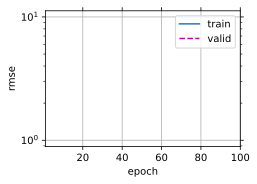

In [39]:
k,num_epochs,lr,weight_decay,batch_size =5,100,5,0.1,64
train_l,valid_l =k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)

print(f'{k}折验证：平均训练log rmse:{float(train_l):f},平均验证 log rmse:{float(valid_l):f}')